In [146]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
os.listdir()

['Deribir_Traiding', '.ipynb_checkpoints', 'Deribit_Trading.ipynb']

In [3]:
with open('Deribir_Traiding', 'r') as file:
    lines = file.readlines()

In [5]:
columns = lines[0].replace('\n', '').split(',')
columns

['exchange',
 'symbol',
 'timestamp',
 'local_timestamp',
 'id',
 'side',
 'price',
 'amount']

In [11]:
def parse_data(data_lines):
    columns = data_lines[0].replace('\n', '').split(',')
    data_dict = {}
    for key in columns:
        data_dict[key] = []
        
    for i in range(1, len(data_lines)):
        data = data_lines[i].replace('\n', '').split(',')
        for idx, key in enumerate(columns):
            data_dict[key].append(data[idx])

    return columns, data_dict

In [26]:
columns, data_dict = parse_data(lines)

In [27]:
df = pd.DataFrame(data_dict)

In [88]:
df.dtypes

timestamp           int64
local_timestamp    object
side                int64
price              object
amount             object
dtype: object

In [28]:
df.head()

,exchange,symbol,timestamp,local_timestamp,id,side,price,amount
0,deribit,BTC-PERPETUAL,1696204800632000,1696204800640191,265755079,buy,28002.5,10
1,deribit,BTC-PERPETUAL,1696204800632000,1696204800640191,265755080,buy,28003,200
2,deribit,BTC-PERPETUAL,1696204800632000,1696204800640191,265755081,buy,28004.5,100
3,deribit,BTC-PERPETUAL,1696204800632000,1696204800640191,265755082,buy,28004.5,10000
4,deribit,BTC-PERPETUAL,1696204800632000,1696204800640191,265755083,buy,28005,17690


In [29]:
df.drop(columns=['exchange', 'symbol', 'id'], inplace=True)

In [30]:
df.tail()

,timestamp,local_timestamp,side,price,amount
88079,1696291180587000,1696291180590726,sell,27512.5,130
88080,1696291186430000,1696291186436876,buy,27513,770
88081,1696291186434000,1696291186439328,buy,27513,2010
88082,1696291190346000,1696291190353858,buy,27516.5,690
88083,1696291199296000,1696291199304812,sell,27516,500


In [31]:
# заменим sell на -1 и buy на 1

d = {'buy': 1, 'sell': -1}
df['side'] = df['side'].map(d)
df.head()

,timestamp,local_timestamp,side,price,amount
0,1696204800632000,1696204800640191,1,28002.5,10
1,1696204800632000,1696204800640191,1,28003,200
2,1696204800632000,1696204800640191,1,28004.5,100
3,1696204800632000,1696204800640191,1,28004.5,10000
4,1696204800632000,1696204800640191,1,28005,17690


In [36]:
df.shape

(88084, 5)

In [45]:
# new_df = df.groupby(['timestamp'])['side', 'price', 'amount']
# new_df.head()

In [89]:
df = df.astype({'timestamp': 'int64', 'price': 'float32', 'amount': 'int32'})

In [98]:
volume_times_price = df['amount'] * df['price']
df.insert(loc = len(df.columns), column='volume_times_price', value = volume_times_price)

In [99]:
df.head()

,timestamp,local_timestamp,side,price,amount,volume_times_price
0,1696204800632000,1696204800640191,1,28002.5,10,280025.0
1,1696204800632000,1696204800640191,1,28003.0,200,5600600.0
2,1696204800632000,1696204800640191,1,28004.5,100,2800450.0
3,1696204800632000,1696204800640191,1,28004.5,10000,280045000.0
4,1696204800632000,1696204800640191,1,28005.0,17690,495408450.0


In [104]:
amounts = df.groupby(['timestamp'])['amount'].sum()
volumes_time_prices =  df.groupby(['timestamp'])['volume_times_price'].sum()
vwap = volumes_time_prices / amounts
vwap

timestamp
1696204800632000    28004.804464
1696204800662000    28005.000000
1696204800670000    28005.000000
1696204807373000    28005.000000
1696204808503000    28007.914297
                        ...     
1696291180587000    27512.500000
1696291186430000    27513.000000
1696291186434000    27513.000000
1696291190346000    27516.500000
1696291199296000    27516.000000
Length: 45872, dtype: float64

In [106]:
amounts_np = df.groupby(['timestamp'])['amount'].sum().to_numpy()

In [96]:
pd.to_datetime(df['timestamp'])

0       1970-01-20 15:10:04.800632
1       1970-01-20 15:10:04.800632
2       1970-01-20 15:10:04.800632
3       1970-01-20 15:10:04.800632
4       1970-01-20 15:10:04.800632
                   ...            
88079   1970-01-20 15:11:31.180587
88080   1970-01-20 15:11:31.186430
88081   1970-01-20 15:11:31.186434
88082   1970-01-20 15:11:31.190346
88083   1970-01-20 15:11:31.199296
Name: timestamp, Length: 88084, dtype: datetime64[ns]

In [114]:
amounts_np.shape

(45872,)

In [108]:
vwap_np = vwap.to_numpy()

In [119]:
# По каждому уникальному значению timestemp - нужно подсчитать количество цен, если они разные - то M0_1, иначе M0_0

date, counts = np.unique(df['timestamp'].to_numpy(), return_counts=True)
len(date), len(counts)

mo = np.where(counts == 1, 'MO_0', 'MO_1')
mo

array(['MO_1', 'MO_0', 'MO_0', ..., 'MO_0', 'MO_0', 'MO_0'], dtype='<U4')

In [128]:
time = pd.to_datetime(np.unique(df['timestamp']), unit='us') + pd.Timedelta(hours=3)
time

DatetimeIndex(['2023-10-02 03:00:00.632000', '2023-10-02 03:00:00.662000',
               '2023-10-02 03:00:00.670000', '2023-10-02 03:00:07.373000',
               '2023-10-02 03:00:08.503000', '2023-10-02 03:00:09.672000',
               '2023-10-02 03:00:10.470000', '2023-10-02 03:00:15.171000',
               '2023-10-02 03:00:15.322000', '2023-10-02 03:00:16.416000',
               ...
               '2023-10-03 02:59:37.003000', '2023-10-03 02:59:37.113000',
               '2023-10-03 02:59:37.114000', '2023-10-03 02:59:37.185000',
               '2023-10-03 02:59:37.196000', '2023-10-03 02:59:40.587000',
               '2023-10-03 02:59:46.430000', '2023-10-03 02:59:46.434000',
               '2023-10-03 02:59:50.346000', '2023-10-03 02:59:59.296000'],
              dtype='datetime64[ns]', length=45872, freq=None)

In [123]:
side = df.groupby(['timestamp'])['side'].mean().to_numpy()

In [121]:
df.head()

,timestamp,local_timestamp,side,price,amount,volume_times_price
0,1696204800632000,1696204800640191,1,28002.5,10,280025.0
1,1696204800632000,1696204800640191,1,28003.0,200,5600600.0
2,1696204800632000,1696204800640191,1,28004.5,100,2800450.0
3,1696204800632000,1696204800640191,1,28004.5,10000,280045000.0
4,1696204800632000,1696204800640191,1,28005.0,17690,495408450.0


In [131]:
new_df = pd.DataFrame({'time': time,
                       'side': side,
                       'amount': amounts_np,
                       'order_type': mo,
                       'vwap': vwap_np})

new_df = new_df.astype({'side': 'int32'})
new_df.head()

,time,side,amount,order_type,vwap
0,2023-10-02 03:00:00.632,1,28000,MO_1,28004.804464
1,2023-10-02 03:00:00.662,1,10650,MO_0,28005.000000
2,2023-10-02 03:00:00.670,1,17370,MO_0,28005.000000
3,2023-10-02 03:00:07.373,1,50,MO_0,28005.000000
4,2023-10-02 03:00:08.503,1,166680,MO_1,28007.914297


In [141]:
side = new_df['side'].to_numpy()

In [152]:
shift = 2
corr = (side[:-shift] - np.mean(side[:-shift]))*(side[shift:] - np.mean(side[shift:]))
corr

array([ 1.08719378,  1.08719378,  1.08719378, ..., -0.99822152,
        1.08719378, -0.99813432])

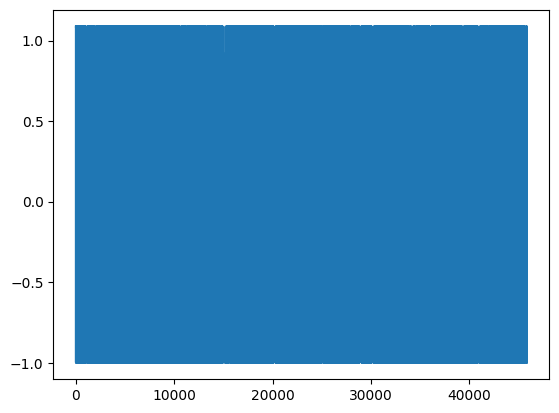

In [154]:
plt.plot(np.arange(len(side[shift:])), corr)